In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import cv2

In [43]:
TOY_DATASET_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/toy_aircraft_dataset_2023.npz"

In [44]:
ds = np.lib.npyio.DataSource(destpath="/tmp/")
f = ds.open(TOY_DATASET_URL, "rb")
toy_dataset = np.load(f)

trainval_images : np.ndarray = toy_dataset["train_images"]
trainval_labels : np.ndarray = toy_dataset["train_labels"]
test_images : np.ndarray = toy_dataset["test_images"]
test_labels : np.ndarray = toy_dataset["test_labels"]
trainval_images.shape, test_images.shape

((2688, 64, 64, 3), (896, 64, 64, 3))

In [45]:
idxs = np.random.permutation(np.arange(trainval_images.shape[0]))

train_idxs, val_idxs = idxs[: int(0.8 * len(idxs))], idxs[int(0.8 * len(idxs)) :]

train_images = trainval_images[train_idxs]
train_labels = trainval_labels[train_idxs]
val_images = trainval_images[val_idxs]
val_labels = trainval_labels[val_idxs]

In [46]:
mean = np.mean(train_images, axis=(0, 1, 2)) / 255.0
std = np.std(train_images, axis=(0, 1, 2)) / 255.0

mean, std

(array([0.32919729, 0.34114028, 0.32183694]),
 array([0.16844265, 0.16507618, 0.1627048 ]))

In [47]:
def preprocessing(image) :
    mean = np.array([0.33012513, 0.34202802, 0.32268534])
    std = np.array([0.16872728, 0.16531856, 0.16314243])
    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Standardize using the mean and std of the dataset
    image = (image - mean) / std

    return image

In [48]:
trainval_images_norm = preprocessing(np.array(trainval_images, copy=True))
test_images_norm = preprocessing(np.array(test_images, copy=True))
trainval_images_norm.shape, test_images_norm.shape

(TensorShape([2688, 64, 64, 3]), TensorShape([896, 64, 64, 3]))

In [49]:
# Le modèle
keras_model = models.Sequential([
    layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(64, 64, 3)),
    layers.Conv2D(16, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(32, kernel_size=3, activation='relu'),
    layers.Conv2D(32, kernel_size=3, activation='relu'),
    layers.Conv2D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid'),
])
keras_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        9248      
                                                      

In [50]:
keras_model.compile(optimizer='adam',
                    loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
                    metrics=['accuracy'])

In [58]:
history = keras_model.fit(trainval_images_norm, trainval_labels, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
68/68 [==============================] - 8s 117ms/step - loss: 0.0135 - accuracy: 0.9944 - val_loss: 0.1323 - val_accuracy: 0.9703
Epoch 2/15
68/68 [==============================] - 8s 115ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.1048 - val_accuracy: 0.9796
Epoch 3/15
68/68 [==============================] - 9s 133ms/step - loss: 0.0059 - accuracy: 0.9986 - val_loss: 0.1662 - val_accuracy: 0.9665
Epoch 4/15
68/68 [==============================] - 9s 125ms/step - loss: 0.0137 - accuracy: 0.9953 - val_loss: 0.1233 - val_accuracy: 0.9684
Epoch 5/15
68/68 [==============================] - 8s 122ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.1686 - val_accuracy: 0.9684
Epoch 6/15
68/68 [==============================] - 8s 117ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.1730 - val_accuracy: 0.9665
Epoch 7/15
68/68 [==============================] - 9s 130ms/step - loss: 0.0320 - accuracy: 0.9912 - val_loss: 0.0666 - val_accuracy: 0.9796
Epoch 

In [64]:
test_loss, test_acc = keras_model.evaluate(test_images_norm, test_labels)
print(f"Test accuracy: {test_acc}")

28/28 [==============================] - 1s 30ms/step - loss: 0.6782 - accuracy: 0.9051
Test accuracy: 0.9051339030265808


In [65]:
keras_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        9248      
                                                      

In [60]:
keras_model.save("./model/aircraft_model.h5")

/home/bolympio/miniconda3/envs/cryptoenv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
keras_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        9248      
                                                      

In [61]:
aircraft_model = tf.keras.models.load_model("./model/aircraft_model.h5")

In [62]:
test_loss, test_acc = aircraft_model.evaluate(test_images_norm, test_labels)
print(f"Test accuracy: {test_acc}")

28/28 [==============================] - 1s 23ms/step - loss: 0.6782 - accuracy: 0.9051
Test accuracy: 0.9051339030265808


In [ ]:
# pip install -q xplique

In [22]:
from xplique.attributions import GradCAM, Lime, Saliency, SmoothGrad

In [13]:
LABEL_NAMES = ["Not an aircraft", "Aircraft"]

print("Labels counts :")
for l, c, label in zip(*np.unique(test_labels, return_counts=True), LABEL_NAMES):
    print(f" Label: {label} , value: {l}, count: {c}")

for l, label in enumerate(LABEL_NAMES):
    print(f"Examples shape for label {l} : {test_images[test_labels == l, ::].shape}")

Labels counts :
 Label: Not an aircraft , value: 0, count: 448
 Label: Aircraft , value: 1, count: 448
Examples shape for label 0 : (448, 64, 64, 3)
Examples shape for label 1 : (448, 64, 64, 3)


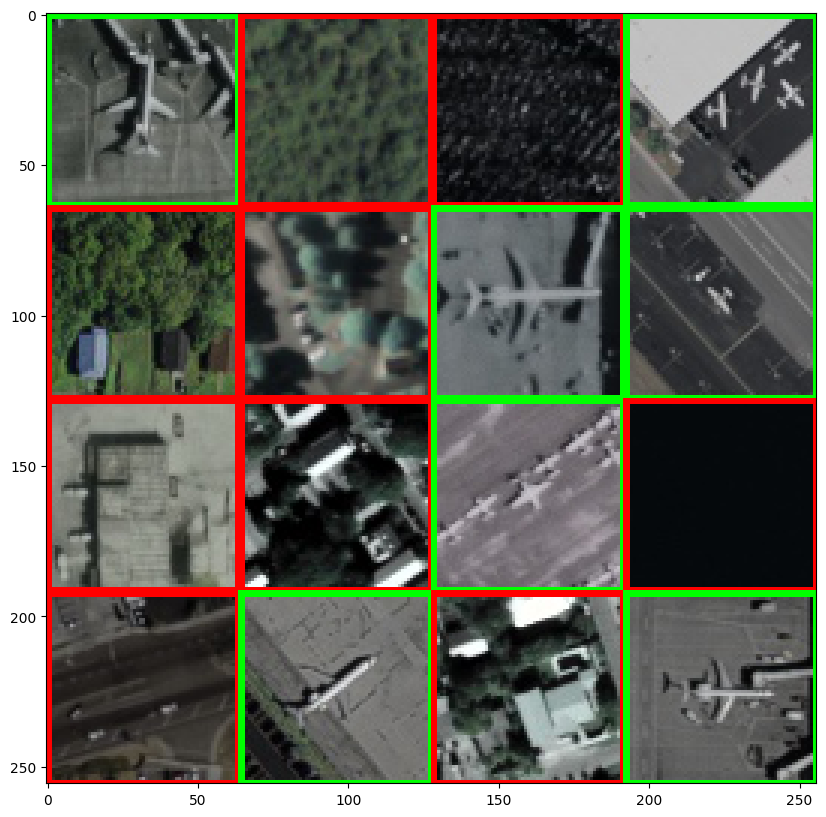

In [14]:
grid_size = 4
grid = np.zeros((grid_size * 64, grid_size * 64, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        tile = np.copy(trainval_images[i * grid_size + j])
        label = np.copy(trainval_labels[i * grid_size + j])
        color = (0, 255, 0) if label == 1 else (255, 0, 0)
        tile = cv2.rectangle(tile, (0, 0), (64, 64), color, thickness=2)
        grid[i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64, :] = tile

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
plt.show()

In [15]:
X = np.array([trainval_images[i] for i in [0,3,6,7,10,13]])
Y = np.array([trainval_labels[i] for i in [0,3,6,7,10,13]])
X.shape
Y


array([1, 1, 1, 1, 1, 1])

In [16]:
output = keras_model.predict((X/255.0 - mean)/std)
output

1/1 [==============================] - 0s 85ms/step


array([[0.9999972 ],
       [0.99999917],
       [0.9999915 ],
       [1.        ],
       [0.9999956 ],
       [1.        ]], dtype=float32)

In [66]:
Y

array([1, 1, 1, 1, 1, 1])

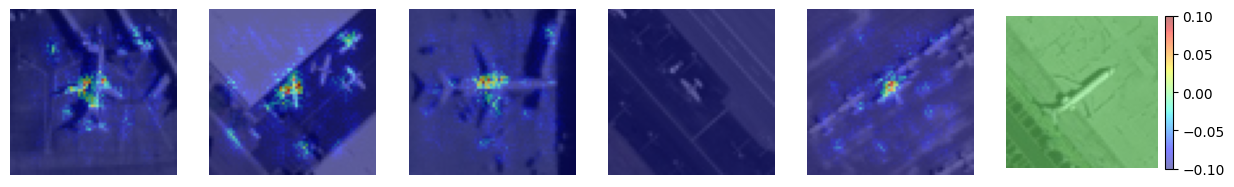

In [24]:
explainer = Saliency(keras_model)
explanations = explainer((X/255.0 - mean)/std, Y)

plt.rcParams["figure.figsize"] = [15, 6]

for i in range(len(X)):
    plt.subplot(1, len(X), i + 1)
    plt.imshow(X[i])
    heatmap = plt.imshow(explanations[i], cmap="jet", alpha=0.5)
    plt.axis('off')

    # Add a color bar to the last subplot
    if i == len(X) - 1:
        plt.colorbar(heatmap, fraction=0.046, pad=0.04)

plt.show()